In [2]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


                               DateTime  Voltage Line 1 [V]  \
DateTime                                                      
2020-08-02 00:00:00 2020-08-02 00:00:00              232.39   
2020-08-02 01:00:00 2020-08-02 01:00:00              234.30   
2020-08-02 02:00:00 2020-08-02 02:00:00              234.14   
2020-08-02 03:00:00 2020-08-02 03:00:00              234.99   
2020-08-02 04:00:00 2020-08-02 04:00:00              233.60   
...                                 ...                 ...   
2020-11-30 19:00:00 2020-11-30 19:00:00              233.59   
2020-11-30 20:00:00 2020-11-30 20:00:00              233.99   
2020-11-30 21:00:00 2020-11-30 21:00:00              233.38   
2020-11-30 22:00:00 2020-11-30 22:00:00              233.50   
2020-11-30 23:00:00 2020-11-30 23:00:00              232.89   

                     Voltage Line 2 [V]  Voltage Line 3 [V]  \
DateTime                                                      
2020-08-02 00:00:00              232.27              2

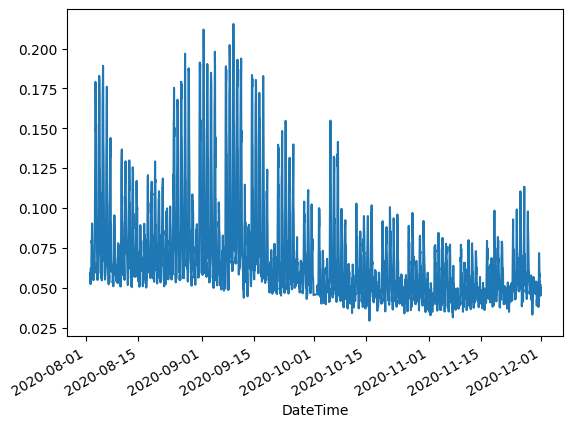

In [3]:
df = pd.read_csv('meter1_combined.csv')
df.DateTime = pd.to_datetime(df.DateTime,dayfirst=True)
df.index = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M:%S')
df["Active Total Energy in MWh"]= df['Active Total Energy (Wh) [Wh]'].astype(float)/ 1000000
df["Combined Active Power in MW"] = df['Combined Active Power Line 1+2 +3 (watt)'].astype(float) / 1000000
print(df)
df['Combined Active Power in MW'].plot()
# plt.show()
target= df['Combined Active Power in MW']

In [5]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  plt.legend(['Actuals','Test Predictions'])
  return df, mse(y, predictions)

# plot_predictions1(model1, X_test1, y_test1)

In [6]:
temp_df = pd.DataFrame({'Power':target,"Avg Temp":df["Temp"],"High Temp":df['Hi'],"Low Temp":df["Low"]})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds
DateTime,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09
...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09


In [7]:

day = 60*60*24
month= 30*day
temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Month sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / month))
temp_df['Month cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / month))
temp_df

,Power,Avg Temp,High Temp,Low Temp,Seconds,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,1.596326e+09,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,1.596330e+09,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,1.596334e+09,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,1.596337e+09,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,1.596341e+09,8.660254e-01,0.500000,-0.719340,0.694658
...,...,...,...,...,...,...,...,...,...
2020-11-30 19:00:00,0.052057,14.4,15.1,14.1,1.606763e+09,-9.659258e-01,0.258819,-0.622515,0.782608
2020-11-30 20:00:00,0.044937,13.7,14.2,13.3,1.606766e+09,-8.660254e-01,0.500000,-0.615661,0.788011
2020-11-30 21:00:00,0.048803,13.4,13.7,13.2,1.606770e+09,-7.071068e-01,0.707107,-0.608761,0.793353


In [8]:
temp_df.drop("Seconds",axis=1,inplace=True)
temp_df.head()

,Power,Avg Temp,High Temp,Low Temp,Day sin,Day cos,Month sin,Month cos
DateTime,,,,,,,,
2020-08-02 00:00:00,0.056684,28.7,29.6,27.6,-4.553737e-12,1.000000,-0.743145,0.669131
2020-08-02 01:00:00,0.059487,26.0,27.4,25.2,2.588190e-01,0.965926,-0.737277,0.675590
2020-08-02 02:00:00,0.052799,25.9,26.9,25.1,5.000000e-01,0.866025,-0.731354,0.681998
2020-08-02 03:00:00,0.055698,25.3,26.4,24.4,7.071068e-01,0.707107,-0.725374,0.688355
2020-08-02 04:00:00,0.052330,24.7,26.3,24.1,8.660254e-01,0.500000,-0.719340,0.694658


In [9]:
#Function to create timeseries for multiple parameters
def df_to_X_y2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
X2, y2 = df_to_X_y2(temp_df)
X2.shape, y2.shape

((2873, 5, 8), (2873,))

In [11]:
X2_train, y2_train = X2[:2000], y2[:2000]
X2_val, y2_val = X2[2000:2435], y2[2000:2435]
X2_test, y2_test = X2[2435:], y2[2435:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((2000, 5, 8), (2000,), (435, 5, 8), (435,), (438, 5, 8), (438,))

In [12]:
#Standardization for the temperatures. Dividing mean/std 
avg_temp_training_mean = np.mean(X2_train[:, :, 1])
avg_temp_training_std = np.std(X2_train[:, :, 1])
hi_temp_training_mean=np.mean(X2_train[:, :, 2])
hi_temp_training_std=np.std(X2_train[:, :, 2])
low_temp_training_mean = np.mean(X2_train[:, :, 3])
low_temp_training_std=np.std(X2_train[:, :, 3])

def preprocess(X):
  X[:, :, 1] = (X[:, :, 1] - avg_temp_training_mean) / avg_temp_training_std
  X[:, :, 2] = (X[:, :, 2] - hi_temp_training_mean) / hi_temp_training_std
  X[:, :, 3] = (X[:, :, 3] - low_temp_training_mean) / low_temp_training_std
  return X

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.16805100e-02, -1.02433919e+00, -1.04766768e+00, ...,
         -9.65925826e-01,  9.76296007e-01, -2.16439614e-01],
        [ 7.08413400e-02, -9.45156173e-01, -1.02796605e+00, ...,
         -8.66025404e-01,  9.74370065e-01, -2.24951054e-01],
        [ 6.86454500e-02, -9.25360420e-01, -9.88562791e-01, ...,
         -7.07106781e-01,  9.72369920e-01, -2.33445364e-01],
        [ 5.90878300e-02, -9.05564666e-01, -9.68861161e-01, ...,
         -5.00000000e-01,  9.70295726e-01, -2.41921896e-01],
        [ 5.94660000e-02, -1.00454343e+00, -1.02796605e+00, ...,
         -2.58819045e-01,  9.68147640e-01, -2.50380004e-01]],

       [[ 7.08413400e-02, -9.45156173e-01, -1.02796605e+00, ...,
         -8.66025404e-01,  9.74370065e-01, -2.24951054e-01],
        [ 6.86454500e-02, -9.25360420e-01, -9.88562791e-01, ...,
         -7.07106781e-01,  9.72369920e-01, -2.33445364e-01],
        [ 5.90878300e-02, -9.05564666e-01, -9.68861161e-01, ...,
         -5.00000000e-01,  9.70295726e-01, -2.41921

In [13]:
model4 = Sequential()
model4.add(InputLayer((5, 8)))
model4.add(GRU(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                14208     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 14,737
Trainable params: 14,737
Non-trainable params: 0
_________________________________________________________________


In [14]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [15]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp4])

Epoch 1/50
63/63 [==============================] - 3s 15ms/step - loss: 0.0261 - root_mean_squared_error: 0.1596 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 2/50
63/63 [==============================] - 0s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 3/50
63/63 [==============================] - 0s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 4/50
63/63 [==============================] - 0s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 6.8666e-04 - val_root_mean_squared_error: 0.0262


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 5/50
63/63 [==============================] - 0s 4ms/step - loss: 9.0423e-04 - root_mean_squared_error: 0.0301 - val_loss: 4.1997e-04 - val_root_mean_squared_error: 0.0205


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 6/50
63/63 [==============================] - 0s 4ms/step - loss: 7.8194e-04 - root_mean_squared_error: 0.0280 - val_loss: 3.0153e-04 - val_root_mean_squared_error: 0.0174


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 7/50
63/63 [==============================] - 0s 4ms/step - loss: 7.0512e-04 - root_mean_squared_error: 0.0265 - val_loss: 2.6632e-04 - val_root_mean_squared_error: 0.0163


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 8/50
63/63 [==============================] - 0s 4ms/step - loss: 6.9848e-04 - root_mean_squared_error: 0.0264 - val_loss: 2.5331e-04 - val_root_mean_squared_error: 0.0159


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 9/50
63/63 [==============================] - 0s 4ms/step - loss: 6.0171e-04 - root_mean_squared_error: 0.0245 - val_loss: 2.9324e-04 - val_root_mean_squared_error: 0.0171
Epoch 10/50
63/63 [==============================] - 0s 4ms/step - loss: 5.5431e-04 - root_mean_squared_error: 0.0235 - val_loss: 2.4774e-04 - val_root_mean_squared_error: 0.0157


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 11/50
63/63 [==============================] - 0s 4ms/step - loss: 5.3430e-04 - root_mean_squared_error: 0.0231 - val_loss: 2.5791e-04 - val_root_mean_squared_error: 0.0161
Epoch 12/50
63/63 [==============================] - 0s 4ms/step - loss: 5.3672e-04 - root_mean_squared_error: 0.0232 - val_loss: 2.1971e-04 - val_root_mean_squared_error: 0.0148


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 13/50
63/63 [==============================] - 0s 4ms/step - loss: 5.0794e-04 - root_mean_squared_error: 0.0225 - val_loss: 2.1837e-04 - val_root_mean_squared_error: 0.0148


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 14/50
63/63 [==============================] - 0s 4ms/step - loss: 4.7378e-04 - root_mean_squared_error: 0.0218 - val_loss: 2.0392e-04 - val_root_mean_squared_error: 0.0143


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 15/50
63/63 [==============================] - 0s 4ms/step - loss: 4.6740e-04 - root_mean_squared_error: 0.0216 - val_loss: 1.9936e-04 - val_root_mean_squared_error: 0.0141


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 16/50
63/63 [==============================] - 0s 4ms/step - loss: 4.4338e-04 - root_mean_squared_error: 0.0211 - val_loss: 2.1368e-04 - val_root_mean_squared_error: 0.0146
Epoch 17/50
63/63 [==============================] - 0s 4ms/step - loss: 4.0831e-04 - root_mean_squared_error: 0.0202 - val_loss: 1.9175e-04 - val_root_mean_squared_error: 0.0138


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 18/50
63/63 [==============================] - 0s 4ms/step - loss: 4.1563e-04 - root_mean_squared_error: 0.0204 - val_loss: 1.9134e-04 - val_root_mean_squared_error: 0.0138


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 19/50
63/63 [==============================] - 0s 4ms/step - loss: 3.9776e-04 - root_mean_squared_error: 0.0199 - val_loss: 1.9060e-04 - val_root_mean_squared_error: 0.0138


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 20/50
63/63 [==============================] - 0s 4ms/step - loss: 3.8131e-04 - root_mean_squared_error: 0.0195 - val_loss: 1.8301e-04 - val_root_mean_squared_error: 0.0135


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 21/50
63/63 [==============================] - 0s 4ms/step - loss: 3.6802e-04 - root_mean_squared_error: 0.0192 - val_loss: 1.9107e-04 - val_root_mean_squared_error: 0.0138
Epoch 22/50
63/63 [==============================] - 0s 4ms/step - loss: 3.4650e-04 - root_mean_squared_error: 0.0186 - val_loss: 1.7264e-04 - val_root_mean_squared_error: 0.0131


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 23/50
63/63 [==============================] - 0s 4ms/step - loss: 3.3989e-04 - root_mean_squared_error: 0.0184 - val_loss: 1.9241e-04 - val_root_mean_squared_error: 0.0139
Epoch 24/50
63/63 [==============================] - 0s 4ms/step - loss: 3.5944e-04 - root_mean_squared_error: 0.0189 - val_loss: 1.8252e-04 - val_root_mean_squared_error: 0.0135
Epoch 25/50
63/63 [==============================] - 0s 4ms/step - loss: 3.4483e-04 - root_mean_squared_error: 0.0185 - val_loss: 1.8951e-04 - val_root_mean_squared_error: 0.0138
Epoch 26/50
63/63 [==============================] - 0s 4ms/step - loss: 3.5540e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.0339e-04 - val_root_mean_squared_error: 0.0143
Epoch 27/50
63/63 [==============================] - 0s 4ms/step - loss: 3.0630e-04 - root_mean_squared_error: 0.0175 - val_loss: 1.7913e-04 - val_root_mean_squared_error: 0.0134
Epoch 28/50
63/63 [==============================] - 0s 4ms/step - loss: 3.1164e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 29/50
63/63 [==============================] - 0s 4ms/step - loss: 3.0206e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.8767e-04 - val_root_mean_squared_error: 0.0137
Epoch 30/50
63/63 [==============================] - 0s 4ms/step - loss: 3.0304e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.6660e-04 - val_root_mean_squared_error: 0.0129


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 31/50
63/63 [==============================] - 0s 4ms/step - loss: 2.9264e-04 - root_mean_squared_error: 0.0171 - val_loss: 2.0079e-04 - val_root_mean_squared_error: 0.0142
Epoch 32/50
63/63 [==============================] - 0s 4ms/step - loss: 2.7794e-04 - root_mean_squared_error: 0.0167 - val_loss: 1.6639e-04 - val_root_mean_squared_error: 0.0129


INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 33/50
63/63 [==============================] - 0s 4ms/step - loss: 2.7506e-04 - root_mean_squared_error: 0.0166 - val_loss: 2.1659e-04 - val_root_mean_squared_error: 0.0147
Epoch 34/50
63/63 [==============================] - 0s 4ms/step - loss: 2.6501e-04 - root_mean_squared_error: 0.0163 - val_loss: 1.9473e-04 - val_root_mean_squared_error: 0.0140
Epoch 35/50
63/63 [==============================] - 0s 4ms/step - loss: 2.5020e-04 - root_mean_squared_error: 0.0158 - val_loss: 1.7677e-04 - val_root_mean_squared_error: 0.0133
Epoch 36/50
63/63 [==============================] - 0s 4ms/step - loss: 2.5238e-04 - root_mean_squared_error: 0.0159 - val_loss: 1.7104e-04 - val_root_mean_squared_error: 0.0131
Epoch 37/50
63/63 [==============================] - 0s 4ms/step - loss: 2.6850e-04 - root_mean_squared_error: 0.0164 - val_loss: 2.0895e-04 - val_root_mean_squared_error: 0.0145
Epoch 38/50
63/63 [==============================] - 0s 4ms/step - loss: 2.6554e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


Epoch 39/50
63/63 [==============================] - 0s 4ms/step - loss: 2.4718e-04 - root_mean_squared_error: 0.0157 - val_loss: 1.7440e-04 - val_root_mean_squared_error: 0.0132
Epoch 40/50
63/63 [==============================] - 0s 4ms/step - loss: 2.5047e-04 - root_mean_squared_error: 0.0158 - val_loss: 1.9161e-04 - val_root_mean_squared_error: 0.0138
Epoch 41/50
63/63 [==============================] - 0s 4ms/step - loss: 2.2359e-04 - root_mean_squared_error: 0.0149 - val_loss: 2.0116e-04 - val_root_mean_squared_error: 0.0142
Epoch 42/50
63/63 [==============================] - 0s 4ms/step - loss: 2.2086e-04 - root_mean_squared_error: 0.0148 - val_loss: 1.9519e-04 - val_root_mean_squared_error: 0.0140
Epoch 43/50
63/63 [==============================] - 0s 4ms/step - loss: 2.2935e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.5366e-04 - val_root_mean_squared_error: 0.0159
Epoch 44/50
63/63 [==============================] - 0s 4ms/step - loss: 2.1090e-04 - root_mean_squared_e

(     Predictions   Actuals
 0       0.052161  0.051650
 1       0.049626  0.052649
 2       0.047813  0.044108
 3       0.045090  0.045328
 4       0.044287  0.037381
 ..           ...       ...
 433     0.019564  0.052057
 434     0.013661  0.044937
 435     0.007239  0.048803
 436     0.005463  0.049585
 437     0.009393  0.046653
 
 [438 rows x 2 columns],
 0.0007206867664464556)

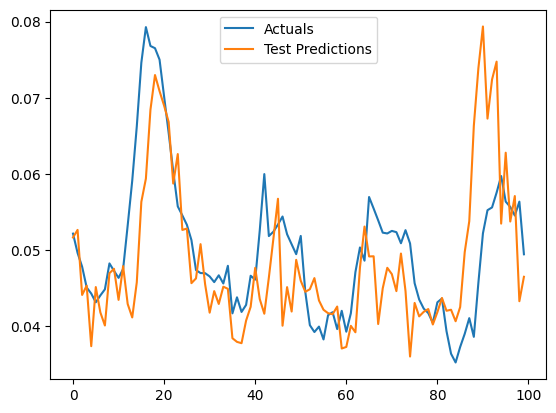

In [16]:
plot_predictions1(model4, X2_test, y2_test)